Import Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from textblob import TextBlob
import requests
from sklearn.svm import SVR

Fetch Data from Yahoo Finance

[*********************100%***********************]  1 of 1 completed


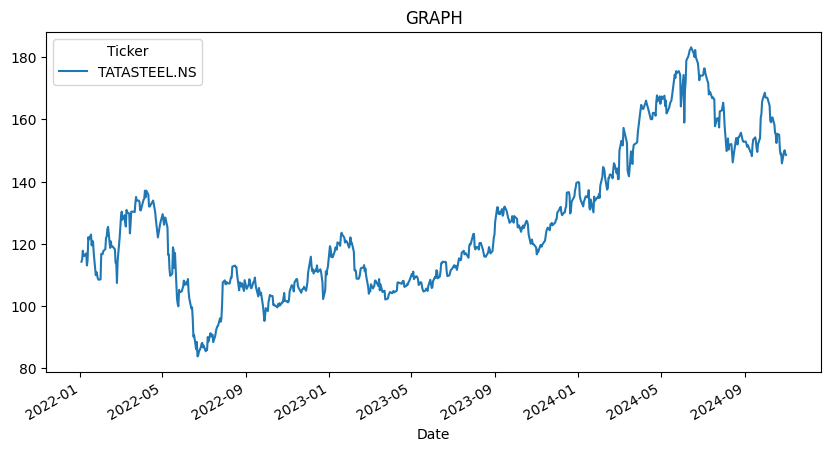

In [ ]:
stock_symbol = 'TATASTEEL.NS'
data = yf.download(stock_symbol, start='2022-01-01', end='2024-11-01')
data['Close'].plot(title="GRAPH", figsize=(10, 5))
plt.show()

[*********************100%***********************]  1 of 1 completed


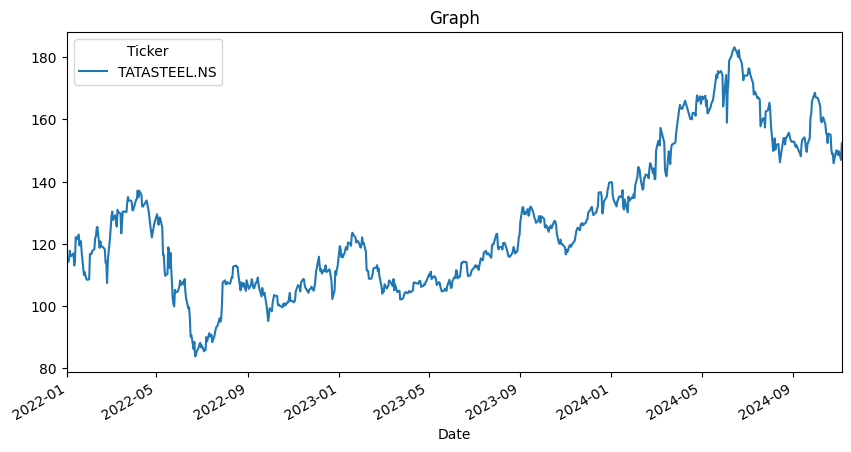

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# Set the stock symbol and start date
stock_symbol = 'TATASTEEL.NS'
start_date = '2022-01-01'

# Fetch the data
data = yf.download(stock_symbol, start=start_date)
last_traded_day = data.index[-1]

# Plot the closing prices
data['Close'].plot(title="GRAPH", figsize=(10, 5))
plt.xlim(start_date, last_traded_day)
plt.title(f"Graph")
plt.show()

Data Preprocessing


In [ ]:
data.reset_index(inplace=True)
data['Target'] = data['Close'].shift(-1)  # Shift to create the target variable
data.dropna(inplace=True)

Creating multiple features

In [ ]:
# Moving Averages
data['SMA'] = data['Close'].rolling(window=20).mean()
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
data['20 Day STD'] = data['Close'].rolling(window=20).std()
data['Upper Band'] = data['SMA'] + (data['20 Day STD'] * 2)
data['Lower Band'] = data['SMA'] - (data['20 Day STD'] * 2)

# RSI
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# ATR
data['TR'] = abs(data['High'] - data['Low'])
data['ATR'] = data['TR'].rolling(window=14).mean()

# MACD
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()

data = data.dropna()
print(data[['Close', 'SMA', 'EMA', 'Upper Band', 'Lower Band', 'RSI', 'ATR', 'MACD']].tail())

Price         Close         SMA         EMA  Upper Band  Lower Band  \
Ticker TATASTEEL.NS                                                   
696      150.059998  156.477000  153.818584  169.580710  143.373291   
697      148.970001  155.574001  153.356814  168.091696  143.056305   
698      148.559998  154.653001  152.899975  166.318740  142.987261   
699      149.750000  153.803001  152.599977  164.161593  143.444408   
700      146.949997  152.932500  152.061884  162.447420  143.417581   

Price         RSI       ATR      MACD  
Ticker                                 
696     33.320985  4.188569 -2.511624  
697     30.390371  4.064998 -2.568487  
698     27.492552  3.862855 -2.616475  
699     33.346281  3.570711 -2.529325  
700     33.204327  3.600711 -2.655584  


Train the Model

In [ ]:
from sklearn.model_selection import train_test_split

X = data[['Close', 'SMA', 'EMA', 'Upper Band', 'Lower Band', 'RSI', 'ATR', 'MACD']]  # features
y = data['Close']  # Target: Closing price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)

Training data size: (545, 8)
Testing data size: (137, 8)


#SAMPLE MODEL - LINEAR REGRESSION

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)


Evaluation Metrics

In [ ]:
metrics = {}

# Ensure y_test and y_pred_linear are flattened
y_test_flat = y_test.values if hasattr(y_test, "values") else y_test
y_pred_linear_flat = y_pred_linear.flatten()  # Ensure y_pred_linear is 1D

# Linear Regression Metrics
metrics['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test_flat, y_pred_linear_flat),
    'MSE': mean_squared_error(y_test_flat, y_pred_linear_flat),
    'R²': r2_score(y_test_flat, y_pred_linear_flat),
    'Accuracy': accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_linear_flat > y_test_flat.mean()).astype(int)) * 100,
    'F1 Score': f1_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_linear_flat > y_test_flat.mean()).astype(int)),
    'Recall': recall_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_linear_flat > y_test_flat.mean()).astype(int)),
    'Precision': precision_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_linear_flat > y_test_flat.mean()).astype(int)),
}
#Display Metrics
print("Linear Regression Metrics:", metrics['Linear Regression'])

Linear Regression Metrics: {'MAE': 8.505767055814339e-15, 'MSE': 2.417484397430581e-28, 'R²': 1.0, 'Accuracy': 100.0, 'F1 Score': 1.0, 'Recall': 1.0, 'Precision': 1.0}


Plot the Graph

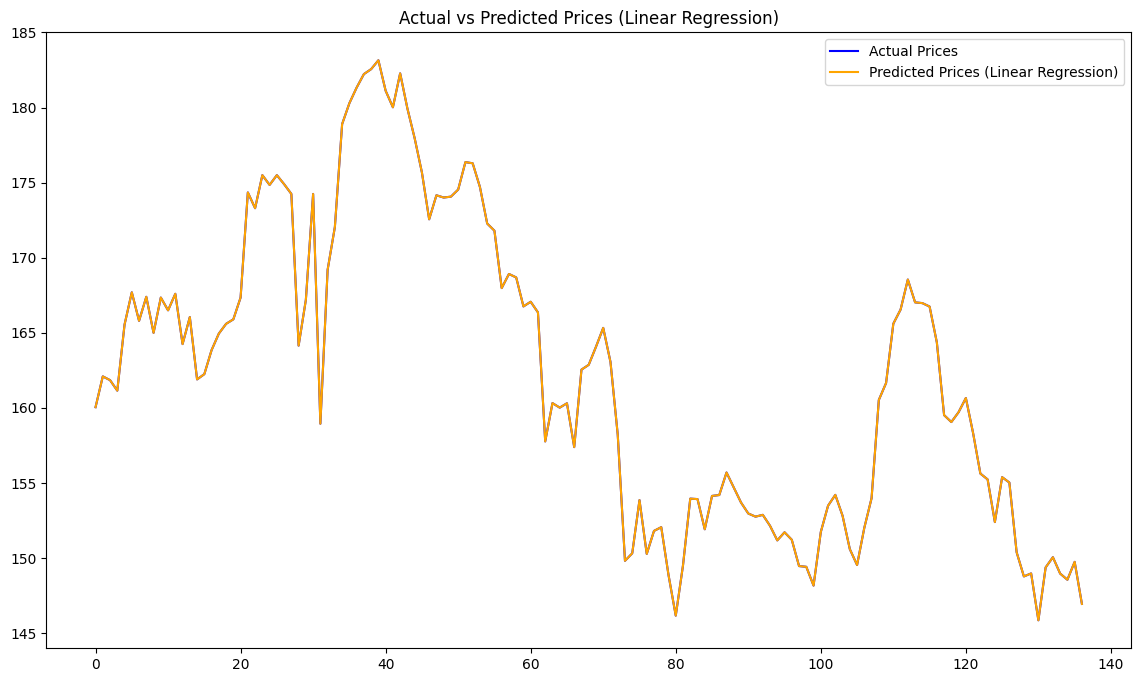

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred_linear, label='Predicted Prices (Linear Regression)', color='orange')
plt.title('Actual vs Predicted Prices (Linear Regression)')
plt.legend()

Tomorrow Price prediction

In [ ]:
X_next = X_test.iloc[-1].values.reshape(1, -1)  # Last available data point
tomorrow_pred_linear = linear_model.predict(X_next)
print(f"Predicted price for tomorrow (Linear Regression): {tomorrow_pred_linear[0]}")

Predicted price for tomorrow (Linear Regression): [146.94999695]


#MODEL 1 - DECISION TREE

In [ ]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
y_pred_dt = decision_tree_model.predict(X_test)

Evaluation Metrics



In [ ]:
# Ensure y_test and y_pred_linear are flattened
y_test_flat = y_test.values if hasattr(y_test, "values") else y_test
y_pred_dt_flat = y_pred_dt.flatten()  # Ensure y_pred_linear is 1D

# Decision Tree Metrics
metrics['Decision Tree'] = {
    'MAE': mean_absolute_error(y_test_flat, y_pred_dt_flat),
    'MSE': mean_squared_error(y_test_flat, y_pred_dt_flat),
    'R²': r2_score(y_test_flat, y_pred_dt_flat),
    'Accuracy': accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_dt_flat > y_test_flat.mean()).astype(int)) * 100,
    'F1 Score': f1_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_dt_flat > y_test_flat.mean()).astype(int)),
    'Recall': recall_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_dt_flat > y_test_flat.mean()).astype(int)),
    'Precision': precision_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_dt_flat > y_test_flat.mean()).astype(int)),
}
#Display Metrics
print("Decision Tree Metrics:", metrics['Decision Tree'])

Decision Tree Metrics: {'MAE': 3.1591973966055544, 'MSE': 30.14406130623147, 'R²': 0.6965106873280598, 'Accuracy': 98.54014598540147, 'F1 Score': 0.9852941176470589, 'Recall': 1.0, 'Precision': 0.9710144927536232}


Plot the Graph

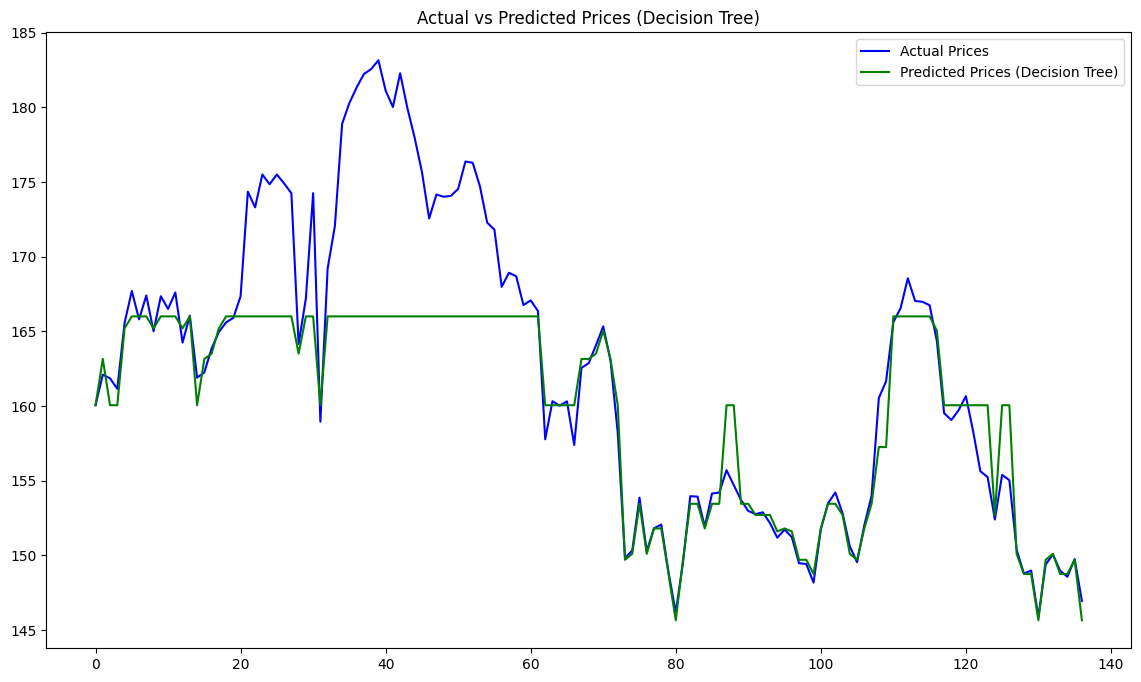

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred_dt, label='Predicted Prices (Decision Tree)', color='green')
plt.title('Actual vs Predicted Prices (Decision Tree)')
plt.legend()

Tomorrow Price prediction

In [ ]:
X_next = X_test.iloc[-1].values.reshape(1, -1)  # Last available data point
tomorrow_pred_dt = decision_tree_model.predict(X_next)
print(f"Predicted price for tomorrow (Decision Tree): {tomorrow_pred_dt[0]}")

Predicted price for tomorrow (Decision Tree): 145.64999389648438


#MODEL 2 - K-Nearest Neighbour

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

Evaluation Metrics

In [ ]:
# Ensure y_test and y_pred_linear are flattened
y_test_flat = y_test.values if hasattr(y_test, "values") else y_test
y_pred_knn_flat = y_pred_knn.flatten()  # Ensure y_pred_linear is 1D
threshold = 0.75

# KNN Metrics
metrics['KNN'] = {
    'MAE': mean_absolute_error(y_test_flat, y_pred_knn_flat),
    'MSE': mean_squared_error(y_test_flat, y_pred_knn_flat),
    'R²': r2_score(y_test_flat, y_pred_knn_flat),
    'Accuracy': accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_knn_flat > y_test_flat.mean()).astype(int)) * 100,
}
#Display Metrics
print("KNN Metrics:", metrics['KNN'])

KNN Metrics: {'MAE': 5.892117677117788, 'MSE': 62.16374051647368, 'R²': 0.37413772182843186, 'Accuracy': 72.99270072992701}


Plot the Graph

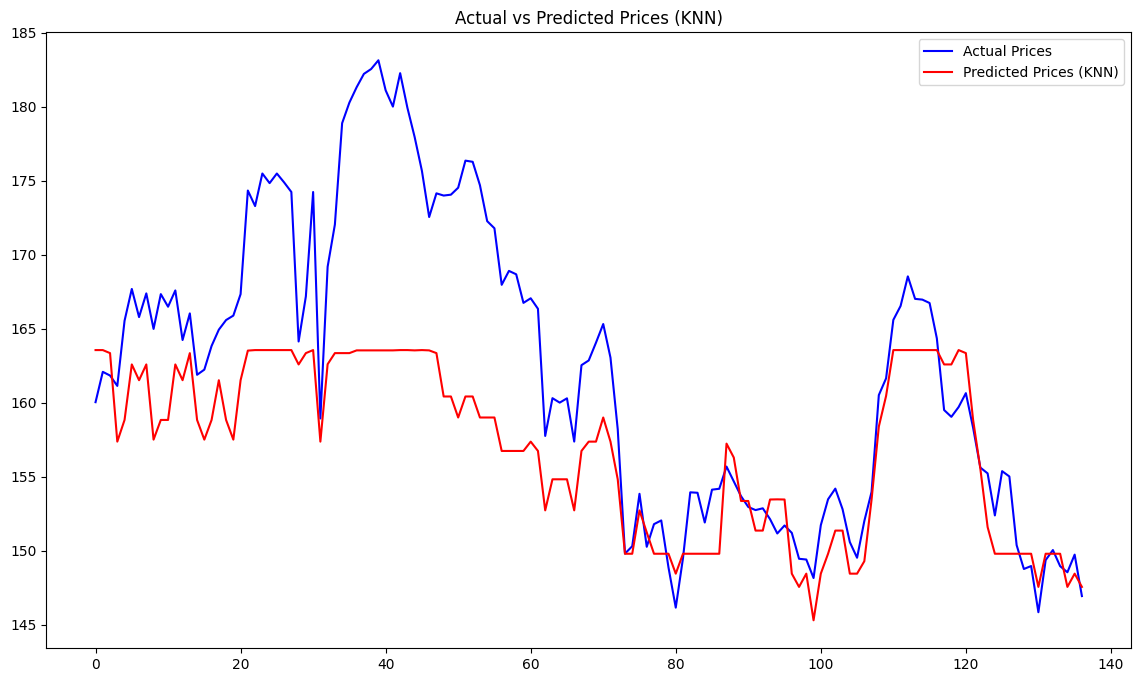

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred_knn, label='Predicted Prices (KNN)', color='red')
plt.title('Actual vs Predicted Prices (KNN)')
plt.legend()

Tomorrow Price prediction

In [ ]:
X_next = X_test.iloc[-1].values.reshape(1, -1)  # Last available data point
tomorrow_pred_knn = knn_model.predict(X_next)
print(f"Predicted price for tomorrow (KNN): {tomorrow_pred_knn[0]}")

Predicted price for tomorrow (KNN): [147.56999817]


#MODEL 3 - SUPPORT VECTOR MACHINE

In [ ]:
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation Metrics

In [ ]:
# Ensure y_test and y_pred_linear are flattened
y_test_flat = y_test.values if hasattr(y_test, "values") else y_test
y_pred_svm_flat = y_pred_svm.flatten()  # Ensure y_pred_linear is 1D

# SVM Metrics
metrics['SVM'] = {
    'MAE': mean_absolute_error(y_test_flat, y_pred_svm_flat),
    'MSE': mean_squared_error(y_test_flat, y_pred_svm_flat),
    'R²': r2_score(y_test_flat, y_pred_svm_flat),
    'Accuracy': accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_svm_flat > y_test_flat.mean()).astype(int)) * 100,
}
#Display Metrics
print("SVM Metrics:", metrics['SVM'])

SVM Metrics: {'MAE': 43.35087313639649, 'MSE': 1980.6047679659566, 'R²': -18.894945696465598, 'Accuracy': 51.09489051094891}


Plat the Graph

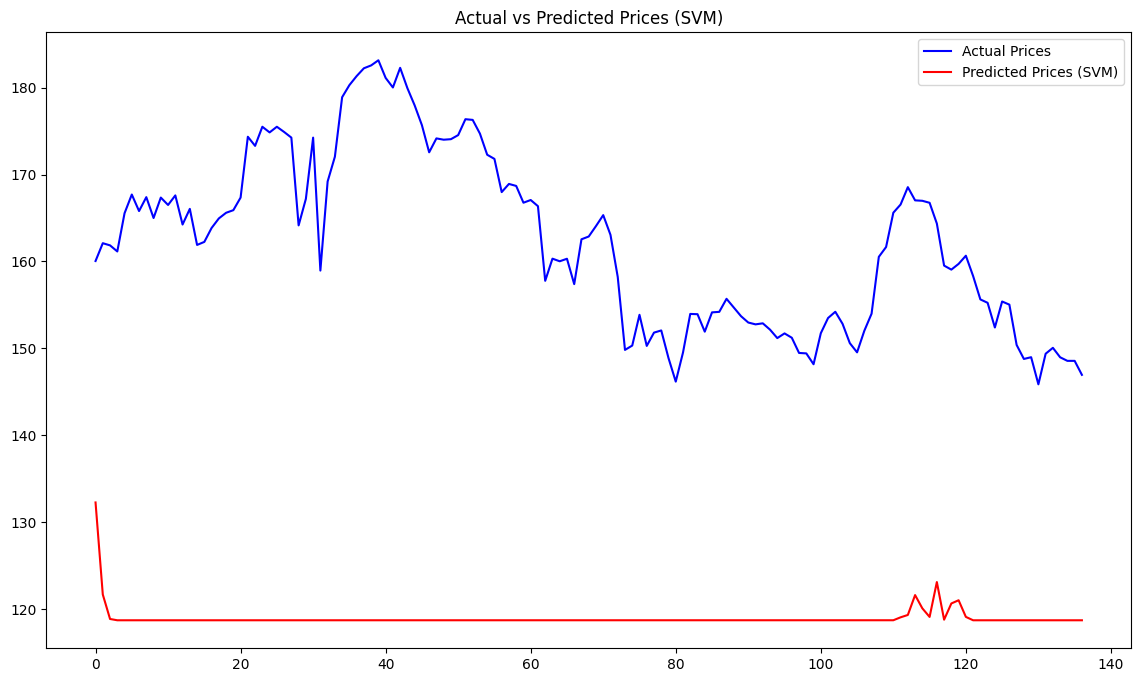

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred_svm, label='Predicted Prices (SVM)', color='red')
plt.title('Actual vs Predicted Prices (SVM)')
plt.legend()

Tomorrow Price prediction

In [ ]:
X_next = X_test.iloc[-1].values.reshape(1, -1)  # Last available data point
tomorrow_pred_svm = svm_model.predict(X_next)
print(f"Predicted price for tomorrow (SVM): {tomorrow_pred_svm[0]}")

Predicted price for tomorrow (SVM): 118.70716808931917


#Ensemble Method

Simple Averaging

In [ ]:
y_pred_avg = (y_pred_knn_flat + y_pred_dt_flat + y_pred_svm_flat) / 3

y_test_flat = y_test.values if hasattr(y_test, "values") else y_test
y_pred_avg_flat = y_pred_avg.flatten()  # Ensure y_pred_linear is 1D

# Evaluate the averaged predictions
mae_avg = mean_absolute_error(y_test_flat, y_pred_avg_flat)
mse_avg = mean_squared_error(y_test_flat, y_pred_avg_flat)
r2_avg = r2_score(y_test_flat, y_pred_avg_flat)
accuracy_avg = accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_avg_flat > y_test_flat.mean()).astype(int)) * 100
print(f"Averaging - MAE: {mae_avg}, MSE: {mse_avg}, R²: {r2_avg}, Accuracy: {accuracy_avg}%")

Averaging - MAE: 19.86971006205994, MSE: 453.8815578468732, R²: -3.5591877249009842, Accuracy: 51.09489051094891%


Weighted Averaging

In [ ]:
# Ensure y_test is a 1D array
y_test_flat = y_test.values.flatten()  # Flatten y_test

# Ensure predictions are also 1D arrays
y_pred_linear = y_pred_linear.flatten()
y_pred_dt = y_pred_dt.flatten()
y_pred_svm = y_pred_svm.flatten()
y_pred_knn = y_pred_knn.flatten()

# Weighted averaging
weights = [0.5, 0.3, 0.2]
y_pred_weighted_avg = (weights[0] * y_pred_dt +
                       weights[1] * y_pred_knn +
                       weights[2] * y_pred_svm)

# Ensure y_pred_weighted_avg is also a 1D array
y_pred_weighted_avg = y_pred_weighted_avg.flatten()

# Now evaluate the weighted average predictions
mae_weighted_avg = mean_absolute_error(y_test_flat, y_pred_weighted_avg)
mse_weighted_avg = mean_squared_error(y_test_flat, y_pred_weighted_avg)
r2_weighted_avg = r2_score(y_test_flat, y_pred_weighted_avg)
accuracy_weighted_avg = accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_weighted_avg > y_test_flat.mean()).astype(int)) * 100
print(f"Weighted Averaging - MAE: {mae_weighted_avg}, MSE: {mse_weighted_avg}, R²: {r2_weighted_avg}, Accuracy: {accuracy_weighted_avg}%")


Weighted Averaging - MAE: 14.031870768431784, MSE: 243.5396127349731, R²: -1.4463272272521523, Accuracy: 51.09489051094891%


Gradient Boosting Machine

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the Gradient Boosting predictions
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)
accuracy_gbm = accuracy_score((y_test_flat > y_test_flat.mean()).astype(int), (y_pred_gbm > y_test_flat.mean()).astype(int)) * 100
print(f"Gradient Boosting Machine - MAE: {mae_gbm}, MSE: {mse_gbm}, R²: {r2_gbm}, Accuracy: {accuracy_gbm}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Gradient Boosting Machine - MAE: 3.8464249667930317, MSE: 34.735630699733704, R²: 0.6510846092663938, Accuracy: 98.54014598540147


In [ ]:
print("\nEnsemble Method Results:")
print(f"Averaging - MAE: {mae_avg}, MSE: {mse_avg}, R²: {r2_avg}, Accuracy:{accuracy_avg}")
print(f"Weighted Averaging - MAE: {mae_weighted_avg}, MSE: {mse_weighted_avg}, R²: {r2_weighted_avg}, Accuracy:{accuracy_weighted_avg}")
print(f"Gradient Boosting Machine - MAE: {mae_gbm}, MSE: {mse_gbm}, R²: {r2_gbm}, Accuracy:{accuracy_gbm}")


Ensemble Method Results:
Averaging - MAE: 19.86971006205994, MSE: 453.8815578468732, R²: -3.5591877249009842, Accuracy:51.09489051094891
Weighted Averaging - MAE: 14.031870768431784, MSE: 243.5396127349731, R²: -1.4463272272521523, Accuracy:51.09489051094891
Gradient Boosting Machine - MAE: 3.8464249667930317, MSE: 34.735630699733704, R²: 0.6510846092663938, Accuracy:98.54014598540147


Tomorrow Price prediction (Ensemble Method)

In [ ]:
# Define models including Gradient Boosting
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
decision_tree_model = DecisionTreeRegressor(random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=50)
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Updated Voting Regressor including Gradient Boosting
voting_model = VotingRegressor(estimators=[
    ('svm', svm_model),
    ('dt', decision_tree_model),
    ('knn', knn_model),
    ('gb', gradient_boosting_model)
])

# Train models and evaluate performance with sentiment feature
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Predict tomorrow's stock price using the voting model(ensemble model)
X_next = X_test.iloc[-1].values.reshape(1, -1)
tomorrow_pred_voting = voting_model.predict(X_next)
print(f"Predicted price for tomorrow (Voting Regressor with Gradient Boosting): {tomorrow_pred_voting[0]}")

Predicted price for tomorrow (Voting Regressor with Gradient Boosting): 139.12235508714969


Sentiment Analysis - NewsAPI

In [ ]:
import requests
from textblob import TextBlob
import numpy as np

newsapi_key = '1f8d8eb84c734f4ca0aa0ad312ffad51'
company_name = 'Tata Steel'
def fetch_newsapi_news(company_name):
    url = f'https://newsapi.org/v2/everything?q={company_name}&apiKey={newsapi_key}'
    response = requests.get(url)

    if response.status_code != 200:
        print(f"NewsAPI Error: Received status code {response.status_code}")
        return 0

    try:
        news_data = response.json()
    except requests.exceptions.JSONDecodeError as e:
        print(f"NewsAPI Error decoding JSON: {e}")
        return 0

    sentiment_scores = []
    for article in news_data.get('articles', []):
        title = article.get('title') or ''
        description = article.get('description') or ''
        text = title + " " + description
        sentiment = TextBlob(text).sentiment.polarity
        sentiment_scores.append(sentiment)

    avg_sentiment_score = np.mean(sentiment_scores) if sentiment_scores else 0
    print(f"NewsAPI Sentiment Score: {avg_sentiment_score}")
    return avg_sentiment_score

# Example Usage
if __name__ == "__main__":
    fetch_newsapi_news(company_name)

NewsAPI Sentiment Score: 0.0932212765409194
